In [4]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# from arch import arch_model

# import seaborn as sns

# from plotly.offline import init_notebook_mode, iplot
# from plotly import graph_objs as go

# from pylab import rcParams

# Initialize plotly
# init_notebook_mode(connected=True)

# from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [5]:
### CARREGAR OS DFS

#bitcoinexplorer
df_difficulty = pd.read_csv('datasets/blockchain_explorer/difficulty.csv',header = None, names=['time_stamp', 'difficulty'])
df_estimated_transaction_volume = pd.read_csv('datasets/blockchain_explorer/estimated-transaction-volume.csv',header = None, names=['time_stamp', 't_volume'])
df_hash_rate = pd.read_csv('datasets/blockchain_explorer/hash-rate.csv',header = None, names=['time_stamp', 'hash_rate'])
df_market_price = pd.read_csv('datasets/blockchain_explorer/market-price.csv',header = None, names=['time_stamp', 'market_price'])
df_mempool_coun = pd.read_csv('datasets/blockchain_explorer/mempool-count.csv',header = None, names=['time_stamp', 'mempool_count'])
df_mempool_size = pd.read_csv('datasets/blockchain_explorer/mempool-size.csv',header = None, names=['time_stamp', 'mempool_size'])
df_n_transactions = pd.read_csv('datasets/blockchain_explorer/n-transactions.csv',header = None, names=['time_stamp', 'n_transactions'])
df_transaction_fees = pd.read_csv('datasets/blockchain_explorer/transaction-fees.csv',header = None, names=['time_stamp', 'transaction-fees'])

#coinmarket
df_coinmarket_price_1h = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_1h.csv', skiprows=1)
df_coinmarket_price_d = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_d.csv', skiprows=1)

#binance
df_binance_price_d = pd.read_csv('datasets/binance_price_data/BTCUSDT_1d_2017-08-17_2020-03-10.csv')
df_binance_price_1h = pd.read_csv('datasets/binance_price_data/BTCUSDT_1h_2017-08-17_2020-03-10.csv')

#kaggle
df_kaggle_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_kaggle_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')
# df_kaggle_price_1min = pd.read_csv('datasets/kaggle/BTCUSD_1min.csv')

In [6]:
### TRANSFORMA EM DATETIME

#bitcoinexplorer
df_difficulty['time_stamp'] = pd.to_datetime(df_difficulty['time_stamp'])
df_estimated_transaction_volume['time_stamp'] = pd.to_datetime(df_estimated_transaction_volume['time_stamp'])
df_hash_rate['time_stamp'] = pd.to_datetime(df_hash_rate['time_stamp'])
df_market_price['time_stamp'] = pd.to_datetime(df_market_price['time_stamp'])
df_mempool_coun['time_stamp'] = pd.to_datetime(df_mempool_coun['time_stamp'])
df_mempool_size['time_stamp'] = pd.to_datetime(df_mempool_size['time_stamp'])
df_n_transactions['time_stamp'] = pd.to_datetime(df_n_transactions['time_stamp'])
df_transaction_fees['time_stamp'] = pd.to_datetime(df_transaction_fees['time_stamp'])

#coinmarket
df_coinmarket_price_1h['Date'] = pd.to_datetime(df_coinmarket_price_1h['Date'], format="%Y-%m-%d %I-%p")
df_coinmarket_price_d['Date'] = pd.to_datetime(df_coinmarket_price_d['Date'], format="%Y-%m-%d")

#binance
df_binance_price_d['close_time'] = pd.to_datetime(df_binance_price_d['close_time'], unit ='ms')
df_binance_price_d['open_time'] = pd.to_datetime(df_binance_price_d['open_time'], unit ='ms')
df_binance_price_1h['close_time'] = pd.to_datetime(df_binance_price_1h['close_time'], unit ='ms')
df_binance_price_1h['open_time'] = pd.to_datetime(df_binance_price_1h['open_time'], unit ='ms')

#kaggle
df_kaggle_price_d['Date'] = pd.to_datetime(df_kaggle_price_d['Date'])
df_kaggle_price_1h['Date'] = pd.to_datetime(df_kaggle_price_1h['Date'])
# df_kaggle_price_1min['Date'] = pd.to_datetime(df_kaggle_price_1min['Date'])

df_kaggle_price_d = df_kaggle_price_d.sort_values(by = ['Date']).reset_index(drop=True)
df_kaggle_price_1h = df_kaggle_price_1h.sort_values(by = ['Date']).reset_index(drop=True)

In [7]:
### VISUALIZA OS TEMPOS MAXIMO E MINIMO
print('------------', 'df_difficulty', '------------')
print(df_difficulty['time_stamp'].max())
print(df_difficulty['time_stamp'].min())
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume['time_stamp'].max())
print(df_estimated_transaction_volume['time_stamp'].min())
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate['time_stamp'].max())
print(df_hash_rate['time_stamp'].min())
print('------------', 'df_market_price', '------------')
print(df_market_price['time_stamp'].max())
print(df_market_price['time_stamp'].min())
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun['time_stamp'].max())
print(df_mempool_coun['time_stamp'].min())
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size['time_stamp'].max())
print(df_mempool_size['time_stamp'].min())
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions['time_stamp'].max())
print(df_n_transactions['time_stamp'].min())
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees['time_stamp'].max())
print(df_transaction_fees['time_stamp'].min())
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d['Date'].max())
print(df_coinmarket_price_d['Date'].min())
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h['Date'].max())
print(df_coinmarket_price_1h['Date'].min())
print('------------', 'df_kaggle_price_d', '------------')
print(df_kaggle_price_d['Date'].max())
print(df_kaggle_price_d['Date'].min())
print('------------', 'df_kaggle_price_1h', '------------')
print(df_kaggle_price_1h['Date'].max())
print(df_kaggle_price_1h['Date'].min())
# print('------------', 'df_kaggle_price_1min', '------------')
# print(df_kaggle_price_1min['Date'].max())
# print(df_kaggle_price_1min['Date'].min())

------------ df_difficulty ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_estimated_transaction_volume ------------
2020-03-10 00:00:00
2010-08-28 00:00:00
------------ df_hash_rate ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_market_price ------------
2020-03-09 00:00:00
2009-01-03 00:00:00
------------ df_mempool_coun ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_mempool_size ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_n_transactions ------------
2020-03-08 00:00:00
2009-01-17 00:00:00
------------ df_transaction_fees ------------
2020-03-08 00:00:00
2009-01-17 00:00:00
------------ df_coinmarket_price_d ------------
2020-04-01 00:00:00
2014-12-01 00:00:00
------------ df_coinmarket_price_1h ------------
2020-04-01 11:00:00
2017-07-01 11:00:00
------------ df_kaggle_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_kaggle_price_1h ------------
2020-04-09 00:00:00
2

In [8]:
### VISUALIZA O TAMANHO DOS DF
print('------------', 'df_difficulty', '------------')
print(df_difficulty.shape[0])
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume.shape[0])
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate.shape[0])
print('------------', 'df_market_price', '------------')
print(df_market_price.shape[0])
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun.shape[0])
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size.shape[0])
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions.shape[0])
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees.shape[0])
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h.shape[0])
print('------------', 'df_kaggle_price_d', '------------')
print(df_kaggle_price_d.shape[0])
print('------------', 'df_kaggle_price_1h', '------------')
print(df_kaggle_price_1h.shape[0])
# print('------------', 'df_kaggle_price_1min', '------------')
# print(df_kaggle_price_1min.shape[0])

------------ df_difficulty ------------
1356
------------ df_estimated_transaction_volume ------------
1735
------------ df_hash_rate ------------
1356
------------ df_market_price ------------
1362
------------ df_mempool_coun ------------
1507
------------ df_mempool_size ------------
1507
------------ df_n_transactions ------------
1357
------------ df_transaction_fees ------------
1357
------------ df_coinmarket_price_d ------------
1937
------------ df_coinmarket_price_1h ------------
24121
------------ df_kaggle_price_d ------------
1646
------------ df_kaggle_price_1h ------------
39468


In [6]:
#verifica se falta alguma data

index = pd.DatetimeIndex(df_kaggle_price_1h['Date'])
print('len index', len(index))
print('start', index[0], '\nend', index[-1])
index_in_range = pd.date_range(index[0], index[-1], freq = 'h')
print('len index_in_range', len(index_in_range))
print('len date missing', len(index_in_range[~index_in_range.isin(index)]))
index_in_range[~index_in_range.isin(index)]

len index 39468
start 2015-10-08 13:00:00 
end 2020-04-09 00:00:00
len index_in_range 39468
len date missing 0


DatetimeIndex([], dtype='datetime64[ns]', freq='H')

In [7]:
#------------ df_coinmarket_price_1h ------------
# nao ha dados faltantes
#------------ df_coinmarket_price_d ------------
# 12 dados faltantes
#------------ df_transaction_fees ------------
# 2712 dados faltantes
# ------------ df_n_transactions ------------
# 2712 dados faltantes
# ------------ df_mempool_size -----------
# não a frequencia nos dados
# ------------ df_mempool_coun ------------
# não a frequencia nos dados
# ------------ df_market_price ------------
# 2722 dados faltantes
# ------------ df_hash_rate ------------
# 2722 dados faltantes
# ------------ df_estimated_transaction_volume ------------
# 1748 dados faltantes
# ------------ df_difficulty ------------
# 2727 dados faltantes
# ------------df_binance_price_d---------
# nao ha dados faltantes
# ------------df_binance_price_1h---------
# 147 dados faltantes
#------------df_kaggle_price_1min--------
# 84462 dados faltantes
#------------df_kaggle_price_1h--------
# nao ha dados faltantes
#------------df_kaggle_price_d--------
# nao ha dados faltantes

In [9]:
df = df_kaggle_price_1h.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39468 entries, 0 to 39467
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Close           39468 non-null  float64       
 1   Date            39468 non-null  datetime64[ns]
 2   High            39468 non-null  float64       
 3   Low             39468 non-null  float64       
 4   Open            39468 non-null  float64       
 5   Symbol          39468 non-null  object        
 6   Unix Timestamp  39468 non-null  int64         
 7   Volume          39468 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.4+ MB


In [10]:
df = df_kaggle_price_d.copy()
# df.info()
df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2015-10-08,BTCUSD,242.50,245.00,242.5,243.95,18.80,4595.84
1,2015-10-09,BTCUSD,243.95,249.97,243.6,245.39,30.99,7651.63
2,2015-10-10,BTCUSD,245.39,246.30,244.6,246.30,12.17,2984.44
3,2015-10-11,BTCUSD,246.30,249.50,246.3,249.50,12.22,3021.12
4,2015-10-12,BTCUSD,249.50,249.50,247.6,247.60,38.28,9493.89


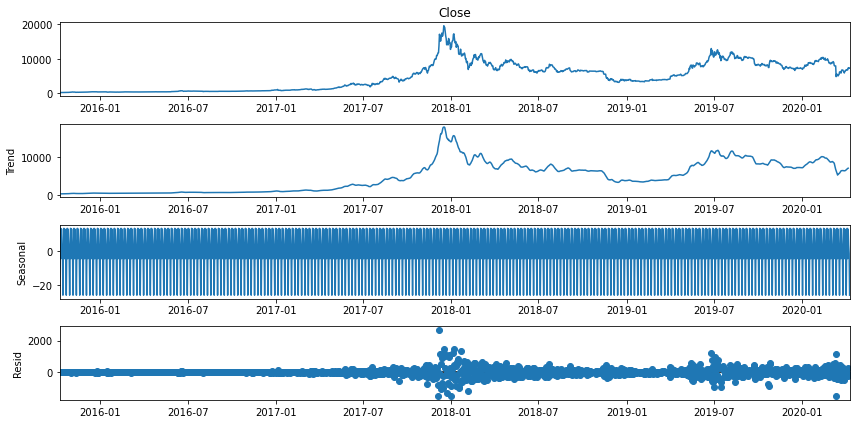

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = df_kaggle_price_d.sort_values(by=['Date']).copy()
df.index = pd.to_datetime(df['Date'])

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

decomposition = seasonal_decompose(df['Close'], model='additive') #multiplicative additive
fig = decomposition.plot()
fname = 'decomposition'
# plt.savefig('/home/ricardo/Documents/tcc_files/TCC/tcc_scripts_notebook/figures/'+fname+'.png', dpi=150)
plt.show()

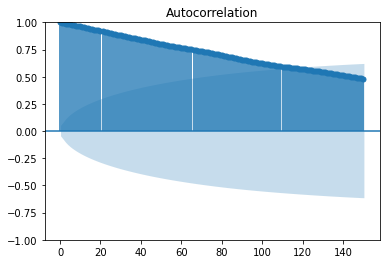

In [18]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

df = df_kaggle_price_d.sort_values(by=['Date']).copy()
df.index = pd.to_datetime(df['Date'])

plot_acf(df['Close'], lags=150)
fname = 'autocorrelation'
# plt.savefig('/home/ricardo/Documents/tcc_files/TCC/tcc_scripts_notebook/figures/'+fname+'.png', dpi=150)
plt.savefig('/home/ricardo/Pictures/'+fname+'.png', dpi=150)

pyplot.show()

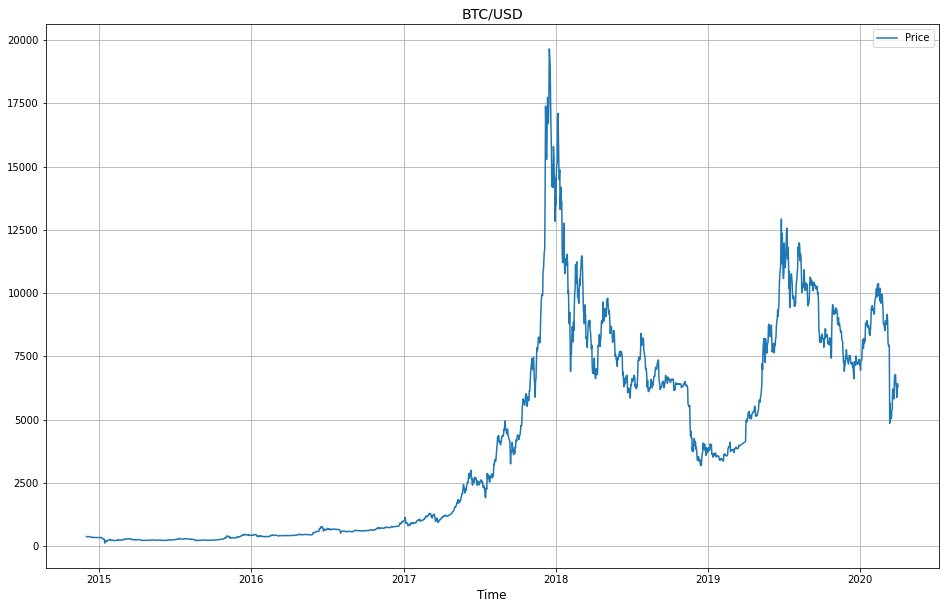

In [12]:
### TESTE GRAFICO
df = df_coinmarket_price_d.copy()
df = df.set_index(df['Date']) #opcional
fig = plt.gcf()
fig.set_size_inches(16,10)
# sns.lineplot(x = 'market_price', y = 'difficulty',  data = df)
plt.plot(df['Close'], label='Price')
#plt.plot(df['Volume USD'], color = 'b', label='volume usd')
#plt.plot(df['Volume BTC'], color = 'r', label='volume btc')
#plt.ylim(6000, 13000)
plt.title('BTC/USD', fontsize = 14)
plt.xlabel('Time', fontsize = 12)
#plt.ylabel('difficulty', fontsize = 12)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,,
2020-04-01,2020-04-01,BTCUSD,6424.35,6437.57,6260.00,6295.77,6287.24,3.973897e+07
2020-03-31,2020-03-31,BTCUSD,6406.40,6524.79,6333.91,6424.35,11772.78,7.595967e+07
2020-03-30,2020-03-30,BTCUSD,5877.21,6631.23,5853.00,6406.40,22757.77,1.435957e+08
2020-03-29,2020-03-29,BTCUSD,6251.82,6279.96,5870.46,5877.21,15449.07,9.361734e+07
2020-03-28,2020-03-28,BTCUSD,6372.36,6372.36,6030.00,6251.82,19731.24,1.226936e+08


In [48]:
# df = df_kaggle_price_1h.copy()
df = df_kaggle_price_d.copy()

percentage_train_size = 0.80

train_size = int(len(df) * percentage_train_size)

d_range = range(3) # [0,1,2]

for d in d_range:

    n_diff = 0
    fitted_data, fitted_lambda = stats.boxcox(df['Close'])
    df['Close'] = fitted_data
    X = df[:train_size]['Close'].values

    while n_diff < d:
        X = np.diff(X)
        n_diff +=1

    result = adfuller(X[d:]) #[d:] exclude the first d nan values
    p_value = result[1]

    if p_value < 0.05:
        print('stationary d:', d)
        #stationary
        break

stationary d: 1


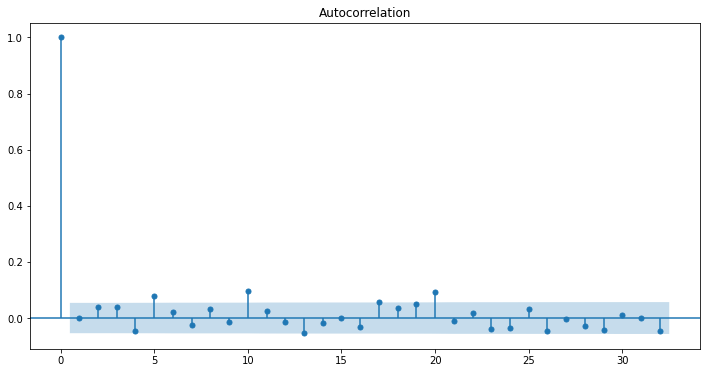

In [51]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

df = X.copy()

plot_acf(df)
fname = 'autocorrelation'
# plt.savefig('/home/ricardo/Documents/tcc_files/TCC/tcc_scripts_notebook/figures/'+fname+'.png', dpi=150)
pyplot.show()

# plot_pacf(df)
# fname = 'partial autocorrelation'
# # plt.savefig('/home/ricardo/Documents/tcc_files/TCC/tcc_scripts_notebook/figures/'+fname+'.png', dpi=150)
# pyplot.show()

In [23]:
def calc_mean_std_of_ts(df):
    
    df['mean'] = 0
    df['std'] = 0
    
    df['rolling_mean'] = df['Close'].rolling(7).mean()
    df['rolling_std'] = df['Close'].rolling(7).std()
    
    for index in df.index:
        
        df.loc[index, 'mean'] = df.loc[:index]['Close'].mean()
        df.loc[index, 'std'] = df.loc[:index]['Close'].std()

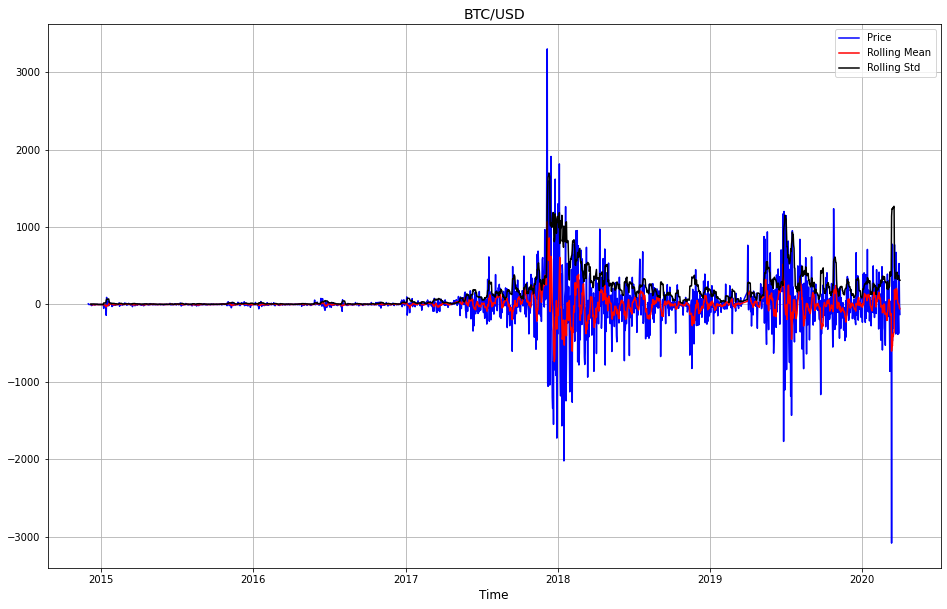

In [44]:
### TESTE GRAFICO
df = df_coinmarket_price_d.copy()
df = df.sort_values(by=['Date']).reset_index(drop=True)
df = df.set_index(df['Date']) #opcional

# fitted_data, fitted_lambda = stats.boxcox(df['Close'])
# inv_boxcox(fitted_data, fitted_lambda)

# df['Close'] = fitted_data
df['Close'] = df['Close'].diff()

calc_mean_std_of_ts(df)

fig = plt.gcf()
fig.set_size_inches(16,10)
# sns.lineplot(x = 'market_price', y = 'difficulty',  data = df)
plt.plot(df['Close'], label='Price', color='blue')
# plt.plot(df['mean'], label='Mean')
plt.plot(df['rolling_mean'], label='Rolling Mean', color='red')
# plt.plot(df['std'], label='Std')
plt.plot(df['rolling_std'], label='Rolling Std', color='black')
#plt.plot(df['Volume USD'], color = 'b', label='volume usd')
#plt.plot(df['Volume BTC'], color = 'r', label='volume btc')
#plt.ylim(6000, 13000)
plt.title('BTC/USD', fontsize = 14)
plt.xlabel('Time', fontsize = 12)
#plt.ylabel('difficulty', fontsize = 12)
plt.grid(True)
plt.legend()
plt.show()

In [45]:
df[['Close']].describe()

,Close
count,1936.000000
mean,3.060832
std,289.128929
min,-3080.950000
25%,-19.567500
50%,0.715000
75%,32.817500
max,3300.010000
